<a href="https://colab.research.google.com/github/saudaminisahoo/HACKATHON_2025/blob/main/3D_DEPTHMODELLING_GRAVITYRESIDUALDATA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Data Import and Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numpy.linalg import inv
from scipy.spatial.distance import cdist
from joblib import Parallel, delayed
# Constants
G = 6.67430e-8  # cm^3 g^-1 s^-2
SI2mGal = 1e3   # 1 cm/s^2 = 1000 mGal

## 1.1 Data Import

In [3]:
# Load gravity data
csv_file='/content/drive/MyDrive/data_2025_hackathon-2025/data_2025_hackathon/RESIDUAL_BA_final.csv'
df = pd.read_csv(csv_file)
df = df.dropna(subset=["BA_residual"])

# 2. Preparation of Rectangular Prisms

##2.1 Setting Grid Parameters

In [4]:
# Grid parameters
dx = dy = 1000  # prism size
dz=200 # prism size
depth_layers = 15
obs_x = df['X'].values
obs_y = df['Y'].values
obs_z = np.zeros_like(obs_x)
obs_xy = df[["X", "Y"]].to_numpy()
obs_coords = np.column_stack([obs_xy, obs_z])
d_obs = df['BA_residual'].values
n_obs = len(d_obs)

## 2.2 Creating Prism Grid

In [5]:
# -------------------- CREATE PRISM GRID --------------------
x_vals = np.sort(np.unique(obs_x))
y_vals = np.sort(np.unique(obs_y))
depth_layers = 15
z_vals = np.arange(0, depth_layers * dz, dz)
nx, ny, nz = len(x_vals), len(y_vals), len(z_vals)

In [6]:
nx,ny,nz

(54, 55, 15)

## 2.3 Calculation of prism centres

In [7]:
# Create prism centers
Xc, Yc, Zc = np.meshgrid(x_vals, y_vals, z_vals, indexing='ij')
prism_centers = np.column_stack([Xc.ravel(), Yc.ravel(), Zc.ravel() + dz / 2])
number_prisms = prism_centers.shape[0]

## 2.4 Defining Prism corners

In [8]:
# Define prism corners (bottom and top)
x1, x2 = Xc.ravel(), Xc.ravel() + dx
y1, y2 = Yc.ravel(), Yc.ravel() + dy
z1, z2 = Zc.ravel(), Zc.ravel() + dz
n_blocks=len(obs_z)
prism_corners = np.column_stack([x1, x2, y1, y2, z1, z2])
model_grid=prism_corners

#3. Initialization of model and Computation of Forward modeling

##3.1 Assign density_contrast values to some rectangular prisms as initial model

In [9]:
densities_contrast = np.ones(number_prisms) * 0

for i, (x, y, z) in enumerate(prism_centers):

    if z > 3000:
        # Below 3 km → fixed density
        densities_contrast[i] =0  # gm/cc

    else:
        # Above 3 km → assign based on anomaly zones

        # HIGH anomaly prisms
        if 635000 <= x <= 660000 and 1580000 <= y <= 1620000:
            densities_contrast[i] = 0.43

        # MEDIUM anomaly prisms
        elif 620000 <= x <= 660000 and 1550000 <= y <= 1580000:
            densities_contrast[i] = 0.08

        # LOW anomaly prisms
        elif 600000 <= x <= 630000 and 1510000 <= y <= 1560000:
            densities_contrast[i] = -0.09

        else:
            # Background (above 3 km but outside anomaly zones)
            densities_contrast[i] = 0

## 3.2 Computation of gravity at observation points

In [10]:
def compute_gravity(obs_coords):
    xi, yi, zi = obs_coords

    xa = np.array([x1 - xi, x2 - xi])
    yb = np.array([y1 - yi, y2 - yi])
    zc = np.array([z1 - zi, z2 - zi])

    gz = np.zeros(number_prisms)

    for a in [0, 1]:
        for b in [0, 1]:
            for c in [0, 1]:
                sign = (-1) ** (a + b + c)

                X = xa[a]
                Y = yb[b]
                Z = zc[c]

                R = np.sqrt(X ** 2 + Y ** 2 + Z ** 2) + 1e-10  # prevent divide by zero

                term = Z * np.arctan2(X * Y, Z * R) \
                       - X * np.log(R + Y + 1e-10) \
                       - Y * np.log(R + X + 1e-10)

                gz += sign * term

    return -G *gz* SI2mGal #for unit density contrast

##3.3 Calculation of sensitivity matrix

In [11]:
def compute_A_row(i):
    return compute_gravity(obs_coords[i])
print("Computing sensitivity matrix A using parallel computing...")
A = Parallel(n_jobs=-1, verbose=5)(delayed(compute_A_row)(i) for i in range(n_obs))
A = np.array(A)
print(f"Sensitivity matrix A shape: {A.shape} (rows = {n_obs}, columns = {number_prisms})")

Computing sensitivity matrix A using parallel computing...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 118 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 298 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 550 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 1270 tasks      | elapsed:   43.4s
[Parallel(n_jobs=-1)]: Done 1738 tasks      | elapsed:   58.3s
[Parallel(n_jobs=-1)]: Done 2278 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2890 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 2961 out of 2961 | elapsed:  1.6min finished


Sensitivity matrix A shape: (2961, 44550) (rows = 2961, columns = 44550)


## 3.4 Computation of Forward modeling

In [12]:
# -------------------- FORWARD MODEL --------------------
d_calc = A @ (densities_contrast) # Predicted gravity (mGal)
residual = d_obs- d_calc
rms = np.sqrt(np.mean(residual ** 2))
print(f"RMS Misfit (rms): {rms:.4f} mGal")


RMS Misfit (rms): 9.7388 mGal


#4. Optimization using Conjugate-gradient Inversion algorithm and calculation of misfit error

## 4.1 Optimization using conjugate gradient algorithm

In [13]:
# Optimization using conjugate-gradient algorithm
target_rms = 0.5       # mGal
max_iters = 300        # maximum CG iterations
beta = 0.001           # regularization parameter

# -------------------- Initialization --------------------
n_prisms = A.shape[1]
m = np.zeros(n_prisms)    # initial density contrast (g/cm³)
m0 = m.copy()             # reference model

# Initial residual and gradient
residual = d_obs - A @ m
grad = -A.T @ residual + beta * (m - m0)
p = -grad


for k in range(max_iters):
    Ap = A @ p
    AtAp = A.T @ Ap + beta * p
    alpha = (grad @ grad) / (p @ AtAp)

    # Update model
    m_updated = m + alpha * p

    # Computation of updated residual and gradient
    residual_updated = d_obs - A @ m_updated
    grad_updated = -A.T @ residual_updated + beta * (m_updated - m0)

    # Computation of RMS
    rms = np.sqrt(np.mean(residual_updated ** 2))


    # Check RMS stop condition
    if rms <= target_rms:
        m = m_updated
        break

    # Conjugate direction update
    beta_k = (grad_updated.T @ grad_updated) / (grad.T @ grad)
    p = -grad_updated + beta_k * p

    # Update model and gradient
    m = m_updated
    grad = grad_updated



## 4.2 Calculation of Misfit error

In [14]:
# Final predicted gravity
d_calc = A @ m
residual = d_obs - d_calc
rms_final = np.sqrt(np.mean(residual**2))
print(f"Final RMS = {rms_final:.4f} mGal")

# Full density model (g/cm³)
density_final = m + 2.6

Final RMS = 0.4448 mGal


# 5. Preparation of 3D density distribution plot and Horizontal depth-slices of 3D density distribution

## 5.1 Preparation of 3D density distribution plot

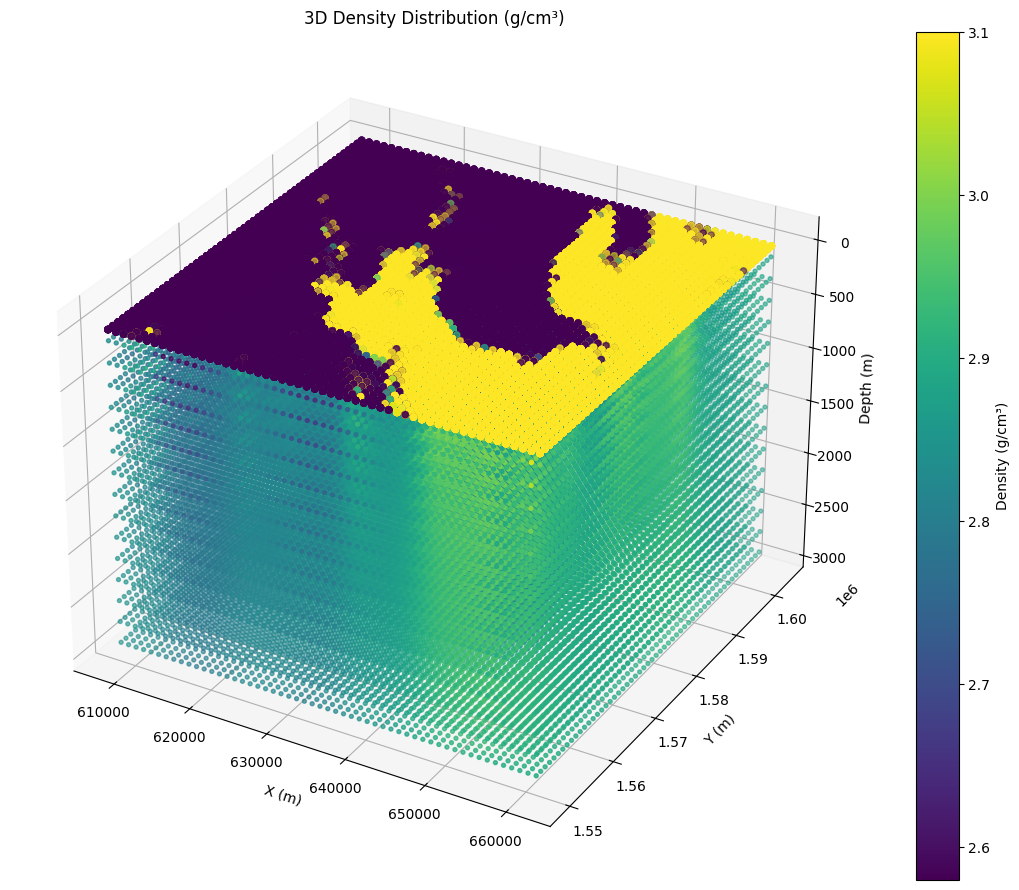

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Convert contrast to actual density in g/cm³
density = m + 2.67

# Extract prism center coordinates from model_grid
x_centers = (model_grid[:, 0] + model_grid[:, 1]) / 2
y_centers = (model_grid[:, 2] + model_grid[:, 3]) / 2
z_centers = (model_grid[:, 4] + model_grid[:, 5]) / 2

# 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot density at each prism center
sc = ax.scatter(x_centers, y_centers, z_centers, c=density, cmap='viridis', s=8)

# Axes settings
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Depth (m)")
ax.set_title("3D Density Distribution (g/cm³)")
ax.invert_zaxis()  # Geophysical convention: depth increases downward

sc = ax.scatter(x_centers, y_centers,
                c=density, cmap='viridis', vmin=2.58, vmax=3.1, s=20)

cbar = plt.colorbar(sc, ax=ax)

cbar.set_label("Density (g/cm³)")

plt.tight_layout()
plt.show()



## 5.2 Horizontal Depth-Slices from the inverted 3D density model

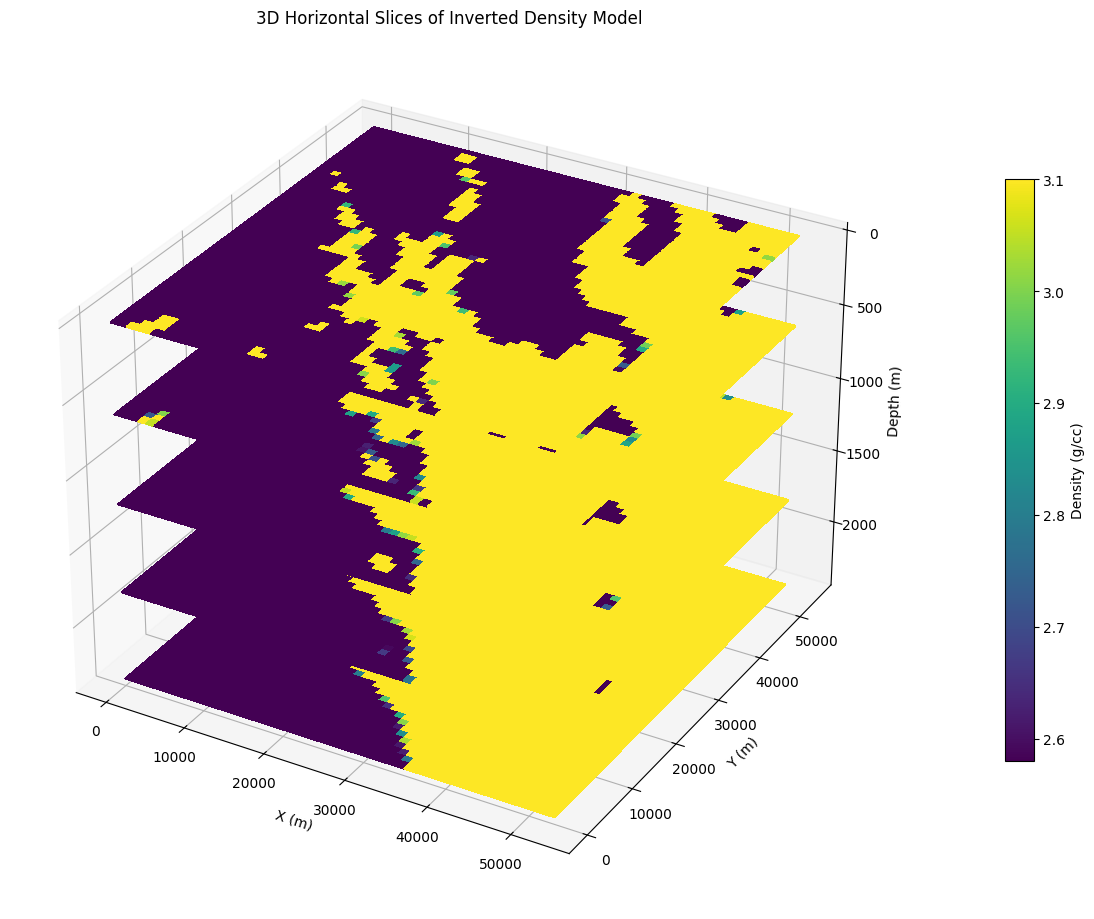

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --- Your inverted density model ---
# Assume density_final is already defined and has shape (nx, ny, nz)
# Example: density_final = np.load('inverted_density.npy')
density_final = density_final.reshape((nx, ny, nz))
nx,ny,nz = density_final.shape

# Grid spacing in meters
dx, dy, dz = 1000, 1000, 200

# Create coordinate grids
x = np.arange(0, nx * dx, dx)
y = np.arange(0, ny * dy, dy)
z = np.arange(0, nz * dz, dz)  # depth in meters

X, Y = np.meshgrid(x, y, indexing='ij')  # shape (nx, ny)

# --- Plotting setup ---
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot slices every 3rd layer up to full depth
for i in range(0, nz, 3):
    Z = np.full_like(X, z[i])  # constant depth for this slice
    slice_data = density_final[:, :, i]  # (nx, ny) slice

    # Normalize for consistent coloring
    normed = (slice_data - 2.58) / (3.1 - 2.58)  # Adjust as needed

    ax.plot_surface(X, Y, Z, facecolors=plt.cm.viridis(normed),
                    rstride=1, cstride=1, antialiased=False, shade=False)

# Add colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([2.58, 3.1])
cbar = plt.colorbar(mappable, ax=ax, shrink=0.6, pad=0.1)
cbar.set_label("Density (g/cc)")

# Axis labels
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")
ax.set_zlabel("Depth (m)")
ax.set_title("3D Horizontal Slices of Inverted Density Model")
ax.invert_zaxis()  # Depth increases downward

plt.tight_layout()
plt.show()
